In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(260, 14859)

In [3]:
results = pd.read_csv('MOB_final_results.csv', index_col=0)

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values

In [4]:
import SpatialDE

In [7]:
histology_results, patterns = SpatialDE.spatial_patterns(X, res, sres, 5)

INFO:root:Iteration 1, log likelihood: -858.11
INFO:root:Iteration 2, log likelihood: -817.42
INFO:root:Iteration 3, log likelihood: -809.84
INFO:root:Iteration 4, log likelihood: -809.00
INFO:root:Converged! Finishing...
INFO:root:Iteration 5, log likelihood: -808.66


In [13]:
K_hat = len(histology_results.pattern.unique())
K_hat

5

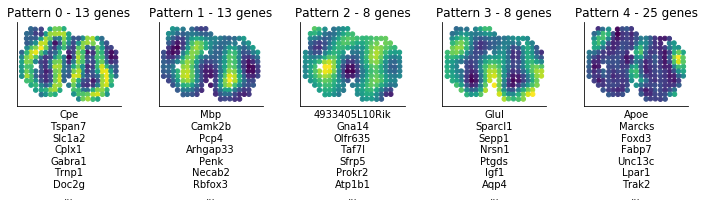

In [18]:
figsize(10, 3)
for i, Ci in enumerate(histology_results.sort_values('pattern').pattern.unique()):
    C = patterns[Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(Ci, histology_results.query('pattern == @Ci').shape[0] ))
    
    xlab = '\n'.join(histology_results.query('pattern == @Ci').sort_values('membership')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('MOB_AEH.pdf', bbox_inches='tight')

In [19]:
for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
Cpe, Tspan7, Slc1a2, Cplx1, Gabra1, Trnp1, Doc2g, Slc6a11, Rab3b, Cck, Cdhr1, Slc17a7, Cdr1

Pattern 1
Mbp, Camk2b, Pcp4, Arhgap33, Penk, Necab2, Rbfox3, Tubb2b, Kcnh3, Ncdn, Baiap2, Gpsm1, Nrgn

Pattern 2
4933405L10Rik, Gna14, Olfr635, Taf7l, Sfrp5, Prokr2, Atp1b1, Pbx1

Pattern 3
Glul, Sparcl1, Sepp1, Nrsn1, Ptgds, Igf1, Aqp4, Igfbp2

Pattern 4
Apoe, Marcks, Foxd3, Fabp7, Unc13c, Lpar1, Trak2, Gng13, Sorbs1, Ccnd1, Kif5b, Apc, Mcf2l, Scd1, Vtn, Sash1, Pmepa1, Igfbp5, Omp, Frzb, Kctd12, Nr2f2, Apod, S100a5, Ptn



In [21]:
histology_results.sort_values('membership', ascending=False).head()

,g,membership,pattern
8913,Cdr1,0.500473,0
12591,Ptn,0.284235,4
10713,S100a5,0.269876,4
8992,Slc17a7,0.257461,0
11114,Nrgn,0.242565,1


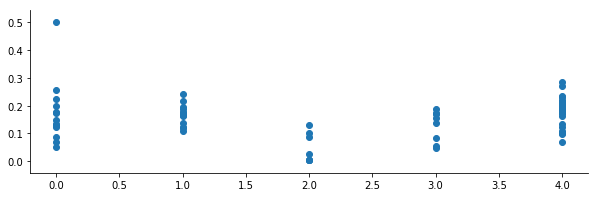

In [23]:
plt.scatter(histology_results.pattern, histology_results.membership);